# キオクシアホールディング 日足

In [1]:
import sys
import os
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

try:
    __file__
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    from pathlib import Path
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '..'))

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

symbol = '285A.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='1mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-05 00:00:00+09:00,1761.0,1761.0,1735.0,1735.0,2009900,0.0,0.0
2025-02-06 00:00:00+09:00,1736.0,1736.0,1710.0,1717.0,1780500,0.0,0.0
2025-02-07 00:00:00+09:00,1702.0,1722.0,1691.0,1697.0,2629900,0.0,0.0
2025-02-10 00:00:00+09:00,1698.0,1797.0,1685.0,1785.0,4231000,0.0,0.0
2025-02-12 00:00:00+09:00,1800.0,1864.0,1786.0,1864.0,5509100,0.0,0.0
2025-02-13 00:00:00+09:00,1864.0,1930.0,1859.0,1929.0,6505500,0.0,0.0
2025-02-14 00:00:00+09:00,1950.0,1988.0,1872.0,1883.0,7156900,0.0,0.0
2025-02-17 00:00:00+09:00,1950.0,2245.0,1950.0,2053.0,31456400,0.0,0.0
2025-02-18 00:00:00+09:00,2100.0,2485.0,2090.0,2359.0,36743800,0.0,0.0


## 日足チャートとパラボリック SAR

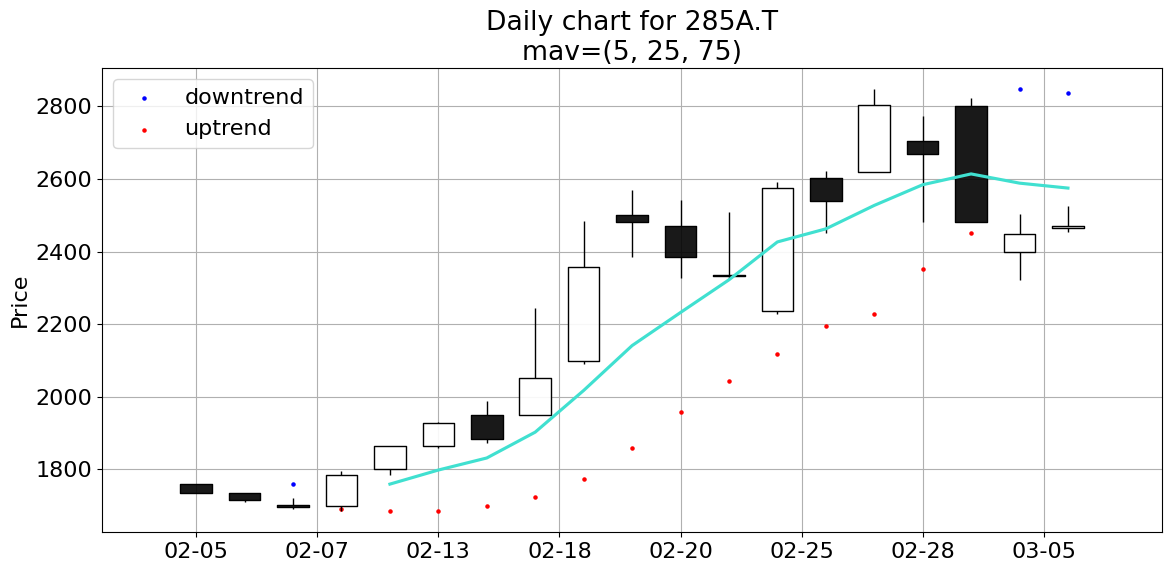

In [6]:
dict_psar = psar(df)

plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()
#ax.legend(loc='best')

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-03-04 00:00:00+09:00    2448.0
2025-03-05 00:00:00+09:00    2471.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-03-04 00:00:00+09:00     NaN
2025-03-05 00:00:00+09:00    23.0
Name: Close, dtype: float64